In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import PReLU, Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

In [ ]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text
df_smile = pd.read_csv('smile-annotations-final.csv', names=['id', 'text', 'category'])
df_smile['text'] = df_smile['text'].apply(clean_text)
sentiment_map = {
    'angry': 'Negative', 'disgust': 'Negative', 'disgust|angry': 'Negative',
    'happy': 'Positive', 'happy|sad': 'Positive',
    'nocode': 'Neutral', 'not-relevant': 'Neutral',
    'sad': 'Negative', 'sad|angry': 'Negative', 'sad|disgust': 'Negative',
    'sad|disgust|angry': 'Negative', 'surprise': 'Neutral'
}
df_smile['category'] = df_smile['category'].map(sentiment_map)

In [ ]:
df_smile.head()

,id,text,category
0,611857364396965889,aandraous britishmuseum andrewsantonio merci p...,Neutral
1,614484565059596288,dorian gray with rainbow scarf lovewins from b...,Positive
2,614746522043973632,selectshowcase tatestives replace with your w...,Positive
3,614877582664835073,sofabsports thank you for following me back gr...,Positive
4,611932373039644672,britishmuseum tudorhistory what a beautiful je...,Positive


In [ ]:
df_smile = df_smile.dropna(subset=['category'])
print("Unique class labels:", df_smile['category'].unique())

Unique class labels: ['Neutral' 'Positive' 'Negative']


In [ ]:
!gdown --id "0B7XkCwpI5KDYNlNUTTlSS21pQmM"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=eb396186-f72f-4c6a-8d99-db0649c9de9e
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:13<00:00, 121MB/s]


In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
def vectorize_sentence(sentence, max_length=39):
    words = sentence.split()
    vectorized = []
    for word in words:
        if word in word_vectors:
            vectorized.append(word_vectors[word])
        else:
            vectorized.append(np.zeros(300))
    if len(vectorized) > max_length:
        vectorized = vectorized[:max_length]
    elif len(vectorized) < max_length:
        vectorized.extend([np.zeros(300) for _ in range(max_length - len(vectorized))])
    return np.array(vectorized)

X = np.array([vectorize_sentence(sentence) for sentence in df_smile['text']])


In [ ]:

le = LabelEncoder()
y = le.fit_transform(df_smile['category'])
y = to_categorical(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, PReLU, MaxPooling1D


model = Sequential()

model.add(Conv1D(50, kernel_size=4, strides=1, input_shape=(39, 300), kernel_regularizer=l2(0.001)))
model.add(PReLU())
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(Conv1D(100, kernel_size=5, strides=1, kernel_regularizer=l2(0.001)))
model.add(PReLU())
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))


model.add(GlobalMaxPooling1D())


model.add(Dense(y_train.shape[1], activation='softmax', kernel_regularizer=l2(0.01)))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 36, 50)            60050     
                                                                 
 p_re_lu_3 (PReLU)           (None, 36, 50)            1800      
                                                                 
 dropout_3 (Dropout)         (None, 36, 50)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 18, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 14, 100)           25100     
                                                                 
 p_re_lu_4 (PReLU)           (None, 14, 100)           1400      
                                                      

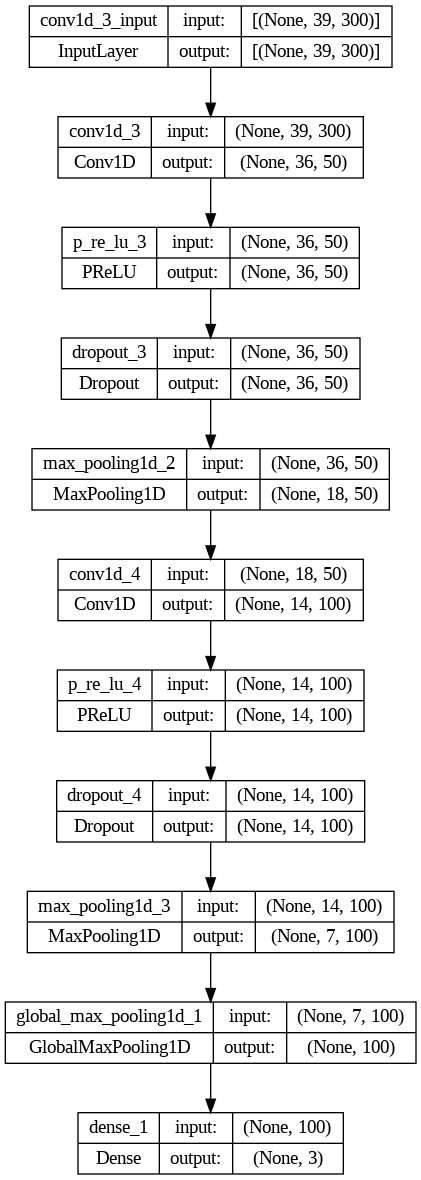

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:

history = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
246/246 [==============================] - 4s 12ms/step - loss: 0.8823 - accuracy: 0.7145 - val_loss: 0.8518 - val_accuracy: 0.7837
Epoch 2/10
246/246 [==============================] - 3s 10ms/step - loss: 0.6781 - accuracy: 0.8081 - val_loss: 0.7213 - val_accuracy: 0.8260
Epoch 3/10
246/246 [==============================] - 3s 13ms/step - loss: 0.5828 - accuracy: 0.8459 - val_loss: 0.6722 - val_accuracy: 0.8341
Epoch 4/10
246/246 [==============================] - 3s 12ms/step - loss: 0.5333 - accuracy: 0.8625 - val_loss: 0.6976 - val_accuracy: 0.8211
Epoch 5/10
246/246 [==============================] - 3s 10ms/step - loss: 0.4858 - accuracy: 0.8808 - val_loss: 0.6670 - val_accuracy: 0.8260
Epoch 6/10
246/246 [==============================] - 3s 11ms/step - loss: 0.4601 - accuracy: 0.8947 - val_loss: 0.6859 - val_accuracy: 0.8276
Epoch 7/10
246/246 [==============================] - 3s 11ms/step - loss: 0.4239 - accuracy: 0.9089 - val_loss: 0.6964 - val_accuracy: 0.8033

In [ ]:
model.save('/content/PaperCNN.keras')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import numpy as np


predictions = model.predict(X_test)


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
conf_matrix2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
print(conf_matrix2)


report = classification_report(true_classes, predicted_classes, target_names=["Positive","Negative","Neutral"])
print("Classification Report:")
print(report)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")


20/20 [==============================] - 0s 7ms/step
Confusion Matrix:
[[  3   7   3]
 [  1 316  61]
 [  0  44 180]]
Classification Report:
              precision    recall  f1-score   support

    Positive       0.75      0.23      0.35        13
    Negative       0.86      0.84      0.85       378
     Neutral       0.74      0.80      0.77       224

    accuracy                           0.81       615
   macro avg       0.78      0.62      0.66       615
weighted avg       0.81      0.81      0.81       615

Accuracy: 0.81138
Precision: 0.81377
Recall: 0.81138
F1 Score: 0.80904
